In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import matplotlib.pyplot as plt 
from collections import deque 

from vehicle_model_DDQN_SOC_dev import Environment 
from cell_model import CellModel 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_e-4wd_Battery.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_id_75_110_Westinghouse.mat"
cell_model = CellModel()
env = Environment(cell_model, drving_cycle, battery_path, motor_path, 1)


In [3]:
# STATE_SIZE = env.calculation_comp["state_size"]
STATE_SIZE = 4
ACTION_SIZE = env.calculation_comp["action_size"] 
LEARNING_RATE = 0.00025 

TOTAL_EPISODES = 200
MAX_STEPS = 50000 

GAMMA = 0.95 

MAX_EPSILON = 1 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
TAU = 0.001 
DELAY_TRAINING = 1000 
EPSILON_MIN_ITER = 5000

In [4]:
primary_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])
target_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])

primary_network.compile(
    loss="mse", 
    optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
)

# for t, p in zip(target_network.trainable_variables, primary_network.trainable_variables): 
#     t.assign(p)

In [5]:
def update_network(primary_network, target_network): 
    for t, p in zip(target_network.trainable_variables, primary_network.trainable_variables): 
        t.assign(t * (1 - TAU) + p * TAU)

In [6]:
class Memory: 
    def __init__(self, max_memory): 
        self.max_memory = max_memory 
        self._samples = [] 
        
    def add_sample(self, sample): 
        self._samples.append(sample)
        if len(self._samples) > self.max_memory: 
            self._samples.pop(0)
        
    def sample(self, no_samples): 
        if no_samples > len(self._samples): 
            return random.sample(self._samples, len(self._samples))
        else: 
            return random.sample(self._samples, no_samples)
    
    @property
    def num_samples(self):
        return len(self._samples)
    

# memory = Memory(10000)

In [7]:
def choose_action(state, primary_network, eps): 
    if random.random() < eps: 
        return random.randint(0, ACTION_SIZE - 1)
    else: 
        return np.argmax(primary_network(np.array(state).reshape(1, -1))) 

In [8]:
def train(primary_network, target_network, memory): 
    batch = memory.sample(BATCH_SIZE)
    states = np.array([val[0] for val in batch]) 
    actions = np.array([val[1] for val in batch])
    rewards = np.array([val[2] for val in batch])
    next_states = np.array([np.zeros(STATE_SIZE) if val[3] is None else val[3]  
                            for val in batch])
    
    prim_qt = primary_network(states)
    prim_qtp1 = primary_network(next_states)
    target_q = prim_qt.numpy() 
    updates = rewards 
    valid_idxs = next_states.sum(axis=1) != 0 
    batch_idxs = np.arange(BATCH_SIZE)
    prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
    q_from_target = target_network(next_states)
    updates[valid_idxs] += GAMMA * q_from_target.numpy()[batch_idxs[valid_idxs], 
                                                        prim_action_tp1[valid_idxs]]
    
    target_q[batch_idxs, actions] = updates 
    loss = primary_network.train_on_batch(states, target_q)
    return loss 
    
    
    

In [9]:
def initialization_with_rewardFactor(reward_factor):
    env = Environment(cell_model, drving_cycle, battery_path, motor_path, reward_factor)
    
    memory = Memory(10000)
    
    primary_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(),  
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    target_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    primary_network.compile(
        loss="mse", 
        optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
    )
    return env, memory, primary_network, target_network 
    

In [10]:
print("environment version: {}".format(env.version)) 

 
reward_factors = [10]
results_dict = {} 

for reward_factor in reward_factors: 
    eps = MAX_EPSILON 
    steps = 0
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    
    env, memory, primary_network, target_network = initialization_with_rewardFactor(reward_factor)
    for episode in range(TOTAL_EPISODES): 
        state = env.reset() 
        avg_loss = 0 
        total_reward = 0
        cnt = 1 

        while True:
            action = choose_action(state, primary_network, eps)
            next_state, reward, done = env.step(action)
            total_reward += reward 
            if done: 
                next_state = None 
            memory.add_sample((state, action, reward, next_state))

            if steps > DELAY_TRAINING: 
                loss = train(primary_network, target_network, memory)
                update_network(primary_network, target_network)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * steps)
            else: 
                loss = -1

            avg_loss += loss 
            steps += 1 

            if done: 
                if steps > DELAY_TRAINING: 
                    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
                    avg_loss /= cnt 
                    print('Episode: {}'.format(episode + 1),
                          'Total reward: {}'.format(total_reward), 
                          'Explore P: {:.4f}'.format(eps), 
                          "SOC: {:.4f}".format(env.SOC), 
                         "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
                         "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
                         )
                else: 
                    print(f"Pre-training...Episode: {i}")
                
                episode_rewards.append(total_reward)
                episode_SOCs.append(env.SOC)
                episode_FCs.append(env.fuel_consumption)
                break 

            state = next_state 
            cnt += 1 
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs 
    }
            
    

environment version: 3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constru

maximum steps, simulation is done ... 
Episode: 40 Total reward: -831.8058641027955 Explore P: 0.3401 SOC: 0.7327 Cumulative_SOC_deviation: 77.6530 Fuel Consumption: 55.2757
maximum steps, simulation is done ... 
Episode: 41 Total reward: -872.3983871191703 Explore P: 0.3311 SOC: 0.7859 Cumulative_SOC_deviation: 81.2800 Fuel Consumption: 59.5980
maximum steps, simulation is done ... 
Episode: 42 Total reward: -748.2492975753456 Explore P: 0.3224 SOC: 0.7393 Cumulative_SOC_deviation: 69.2412 Fuel Consumption: 55.8372
maximum steps, simulation is done ... 
Episode: 43 Total reward: -860.751698101478 Explore P: 0.3140 SOC: 0.7452 Cumulative_SOC_deviation: 80.4382 Fuel Consumption: 56.3698
maximum steps, simulation is done ... 
Episode: 44 Total reward: -855.4508835384 Explore P: 0.3057 SOC: 0.7309 Cumulative_SOC_deviation: 80.0249 Fuel Consumption: 55.2022
maximum steps, simulation is done ... 
Episode: 45 Total reward: -988.0937514146059 Explore P: 0.2977 SOC: 0.7854 Cumulative_SOC_devia

maximum steps, simulation is done ... 
Episode: 88 Total reward: -696.2516964799481 Explore P: 0.0983 SOC: 0.7183 Cumulative_SOC_deviation: 64.2468 Fuel Consumption: 53.7837
maximum steps, simulation is done ... 
Episode: 89 Total reward: -684.1149832697204 Explore P: 0.0960 SOC: 0.6952 Cumulative_SOC_deviation: 63.2083 Fuel Consumption: 52.0323
maximum steps, simulation is done ... 
Episode: 90 Total reward: -806.2906053587953 Explore P: 0.0936 SOC: 0.7054 Cumulative_SOC_deviation: 75.3406 Fuel Consumption: 52.8842
maximum steps, simulation is done ... 
Episode: 91 Total reward: -758.3520768105654 Explore P: 0.0914 SOC: 0.7020 Cumulative_SOC_deviation: 70.5817 Fuel Consumption: 52.5355
maximum steps, simulation is done ... 
Episode: 92 Total reward: -775.169247329825 Explore P: 0.0892 SOC: 0.7146 Cumulative_SOC_deviation: 72.1672 Fuel Consumption: 53.4969
maximum steps, simulation is done ... 
Episode: 93 Total reward: -631.2324196222174 Explore P: 0.0870 SOC: 0.7088 Cumulative_SOC_de

maximum steps, simulation is done ... 
Episode: 135 Total reward: -1191.901988524425 Explore P: 0.0343 SOC: 0.6554 Cumulative_SOC_deviation: 114.1773 Fuel Consumption: 50.1288
maximum steps, simulation is done ... 
Episode: 136 Total reward: -1825.193727660532 Explore P: 0.0336 SOC: 0.9138 Cumulative_SOC_deviation: 175.3899 Fuel Consumption: 71.2945
maximum steps, simulation is done ... 
Episode: 137 Total reward: -2199.940686429622 Explore P: 0.0330 SOC: 1.0000 Cumulative_SOC_deviation: 211.9312 Fuel Consumption: 80.6284
maximum steps, simulation is done ... 
Episode: 138 Total reward: -1317.911854643511 Explore P: 0.0324 SOC: 0.8387 Cumulative_SOC_deviation: 125.5136 Fuel Consumption: 62.7755
maximum steps, simulation is done ... 
Episode: 139 Total reward: -1211.6887132269474 Explore P: 0.0318 SOC: 0.8163 Cumulative_SOC_deviation: 115.0440 Fuel Consumption: 61.2486
Available condition is not avail... SOC: 0.995269197220357
Episode: 140 Total reward: -2310.769006519962 Explore P: 0.0

maximum steps, simulation is done ... 
Episode: 181 Total reward: -1812.8559229318478 Explore P: 0.0169 SOC: 0.4974 Cumulative_SOC_deviation: 177.4769 Fuel Consumption: 38.0872
maximum steps, simulation is done ... 
Episode: 182 Total reward: -2018.7134942125501 Explore P: 0.0168 SOC: 0.5683 Cumulative_SOC_deviation: 197.6668 Fuel Consumption: 42.0456
maximum steps, simulation is done ... 
Episode: 183 Total reward: -349.51261584027696 Explore P: 0.0166 SOC: 0.6154 Cumulative_SOC_deviation: 30.4807 Fuel Consumption: 44.7057
maximum steps, simulation is done ... 
Episode: 184 Total reward: -1842.6876921684213 Explore P: 0.0164 SOC: 0.5327 Cumulative_SOC_deviation: 180.3749 Fuel Consumption: 38.9391
maximum steps, simulation is done ... 
Episode: 185 Total reward: -1183.5113511960665 Explore P: 0.0162 SOC: 0.8572 Cumulative_SOC_deviation: 111.9395 Fuel Consumption: 64.1160
maximum steps, simulation is done ... 
Episode: 186 Total reward: -786.135788709153 Explore P: 0.0161 SOC: 0.7797 Cu

In [12]:
with open("results_unNorm.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

TypeError: float() argument must be a string or a number, not 'dict'

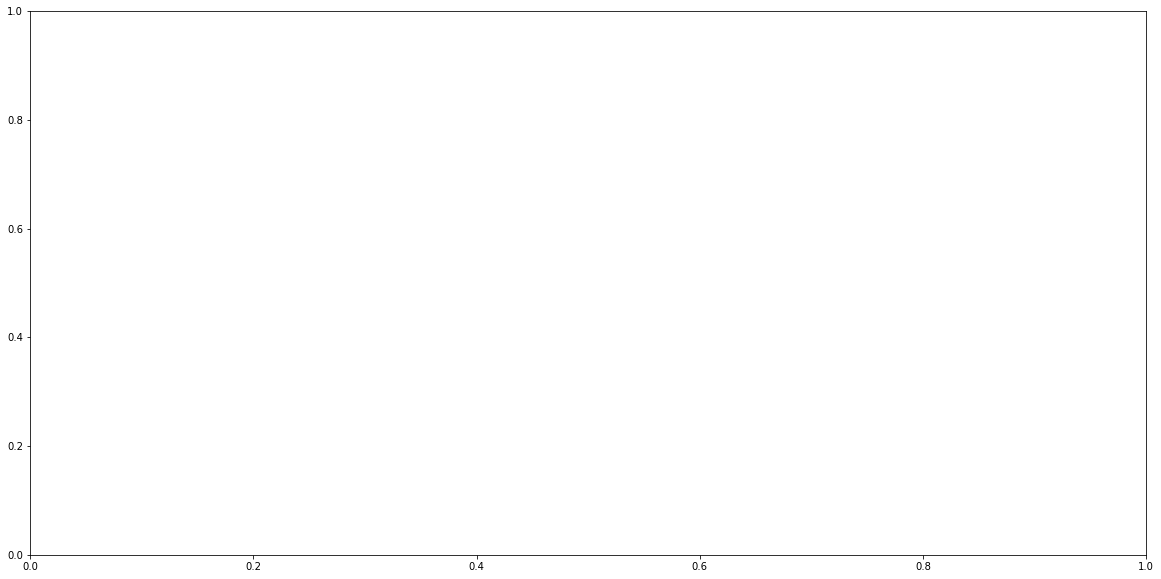

In [11]:
plt.figure(figsize=(20, 10))
for size, history in results_dict.items(): 
    plt.plot(history, label=size, linewidth=3.0) 


plt.grid() 
plt.legend(fontsize=20)
plt.xlabel("episode number", fontsize=20) 
plt.ylabel("total rewards", fontsize=20) 
plt.xlim([0, 120])


plt.savefig("replay_memory_size_effect_300.png")
with open("replay_memory_size_effect_300.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("results/replay_memory_size_effect.pkl", "rb") as f: 
    data = pickle.load(f)
    
data

In [ ]:
-(3 > 2) * 2
